In [1]:
#NB: Kaggle requires phone verification to use the internet or a GPU. If you haven't done that yet, the cell below will fail
#    This code is only here to check that your internet is enabled. It doesn't do anything else.
#    Here's a help thread on getting your phone number verified: https://www.kaggle.com/product-feedback/135367

import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [2]:
# It's a good idea to ensure you're running the latest version of any libraries you need.
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>
# NB: You can safely ignore any warnings or errors pip spits out about running as root or incompatibilities
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai duckduckgo_search

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.8 which is incompatible.
apache-beam 2.46.0 requires numpy<1.25.0,>=1.14.3, but you have numpy 1.26.4 which is incompatible.
apache-beam 2.46.0 requires pyarrow<10.0.0,>=3.0.0, but you have pyarrow 15.0.2 which is incompatible.


In [3]:
# from duckduckgo_search import ddg_images
from duckduckgo_search import DDGS
from fastcore.all import *

ddgs = DDGS()

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
#     return L(ddg_images(term, max_results=max_images)).itemgot('image')
    return L(ddgs.images(keywords=term, max_results=max_images)).itemgot('image')

In [4]:
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you get a JSON error, just try running it again (it may take a couple of tries).
urls = search_images('black labrador photos', max_images=1)
urls[0]

Searching for 'black labrador photos'


'http://www.thelabradorsite.com/wp-content/uploads/2011/12/english-black-lab-puppy.jpg'

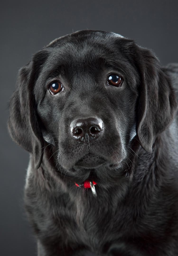

In [5]:
#downloads black lab photos and then sizes it. we need to confirm this is the right photo
from fastdownload import download_url
dest = 'blacklab.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Searching for 'poodles'


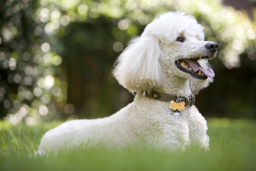

In [6]:
#downloads an image of a poodle, and opens it to confirm
download_url(search_images('poodles', max_images=1)[0], 'poodle.jpg', show_progress=False)
Image.open('poodle.jpg').to_thumb(256,256)
#confirmed search works

In [7]:
#gather more pictures of black labs vs other dogs and save to folder to train and test later with different conditions (puppy/adult, colors)
searches = 'poodles','blacklab'
path = Path('blacklab_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} puppy photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} adult photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} black photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'poodles photo'
Searching for 'poodles puppy photo'
Searching for 'poodles adult photo'
Searching for 'poodles black photo'
Searching for 'blacklab photo'
Searching for 'blacklab puppy photo'
Searching for 'blacklab adult photo'
Searching for 'blacklab black photo'


In [8]:
#start to train model
#filter out any failed images
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

3

To train a model, we'll need `DataLoaders`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it:

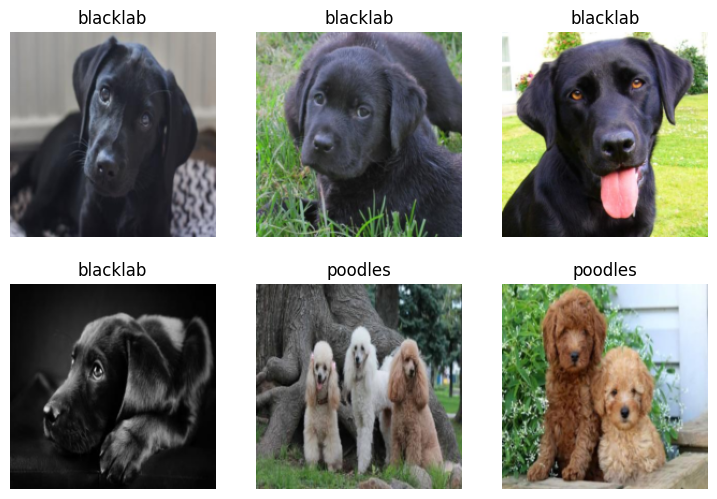

In [9]:
#using DataLoaders (object containing a training set + validation set)
#DataBlock is a fastAI component to use dataloader + view sample images via show_batch
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [10]:
#fastai comes with fine_time() method that automatically uses best practices for a pre-trained model
#resnet is the fastest widely used model
#fine-tuning lets us use a pre-trained model and adjust weights to recognize our dataset. resnet18 was trained to recognize photos from 1000 categories
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 125MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,0.871123,0.059127,0.022727,00:02


epoch,train_loss,valid_loss,error_rate,time
0,0.014961,0.012269,0.000000,00:01
1,0.011674,0.000916,0.000000,00:01
2,0.008159,0.000342,0.000000,00:01


In [11]:
## Step 3: Use our dog-trained model

In [12]:
#model predicting if photo in validation set is a dog
is_dog,_,probs = learn.predict(PILImage.create('blacklab.jpg'))
print(f"This is a: {is_dog}.")
print(f"Probability it's a black lab: {probs[0]:.4f}")


This is a: blacklab.
Probability it's a black lab: 1.0000
